# Discretized Full Hamiltonian

#### **Tight-Binding Matrix** 

In [2]:
import numpy as np

from scipy.sparse import bmat
from scipy.linalg import ishermitian


# Hamiltonian parameters
params=dict(C0 = -0.0068, D1 = 1.3, D2 = 19.6, A1 = 2.2, A2 = 4.1, M = 0.28, B1 = 10, B2 = 56.6)

# Set of Pauli matrices for spin
sigma0 = np.array([[1, 0], [0, 1]])
sigmaX = np.array([[0, 1], [1, 0]])
sigmaY = np.array([[0, -1j], [1j, 0]])
sigmaZ = np.array([[1, 0], [0, -1]])

# Set of Pauli matrices for pseudo-spin
lambda0 = np.array([[1, 0], [0, 1]])
lambdaX = np.array([[0, 1], [1, 0]])
lambdaY = np.array([[0, -1j], [1j, 0]])
lambdaZ = np.array([[1, 0], [0, -1]])

# Set of Pauli matrices for particle-hole
tau0 = np.array([[1, 0], [0, 1]])
tauX = np.array([[0, 1], [1, 0]])
tauY = np.array([[0, -1j], [1j, 0]])
tauZ = np.array([[1, 0], [0, -1]])


# Function defining the Matrices a,b,c for the MTI
def abcMTI(kx, ky, L, C0 = -0.0068, D1 = 1.3, D2 = 19.6, A1 = 2.2, A2 = 4.1, M = 0.28, B1 = 10, B2 = 56.6):

    k = np.sqrt(kx**2+ky**2); e0 = C0 + D2*k**2; m0 = M - B2*k**2

    #matrix A
    amat = B1*np.kron(lambdaZ, sigma0) - D1*np.kron(lambda0, sigma0)

    # matrix B
    bmat = -1j*A1*np.kron(lambdaX, sigmaZ)

    # matrix C
    cmat = e0*np.kron(lambda0, sigma0) + L*np.kron(lambda0, sigmaZ) + A2*( kx*np.kron(lambdaX, sigmaX) + ky*np.kron(lambdaX, sigmaY) ) + m0*np.kron(lambdaZ, sigma0)

    return [amat, bmat, cmat]


# Function defining the Matrices alpha and gamma for the SC
def abcSC(kx, ky, mu, Delta, t=1.):
        
    E0 = t*(kx**2+ky**2)

    # make Delta complex if real
    if isinstance(Delta, float):
        Delta = complex(Delta)

    # matrix alpha
    alpha = -t*np.kron(tauZ, sigma0)

    # matrix beta
    beta = np.zeros((4,4))

    # matrix gamma 
    gamma = (E0-mu)*np.kron(tauZ, sigma0) - Delta.real*np.kron(tauY, sigmaY) - Delta.imag*np.kron(tauX, sigmaY)

    return [alpha, beta, gamma]


# Function defining the Matrices A,B,C in the different cases
def ABCmatrices(kx, ky, mu, Delta, L, dZ, G, C0 = -0.0068, D1 = 1.3, D2 = 19.6, A1 = 2.2, A2 = 4.1, M = 0.28, B1 = 10, B2 = 56.6, t = 1.):

    # MTI a,b,c matrices
    a,b,c = abcMTI(kx=kx, ky=ky, L=L, C0=C0, D1=D1, D2=D2, A1=A1, A2=A2, M=M, B1=B1, B2=B2)

    # SC alpha and gamma matrices
    alpha, beta, gamma = abcSC(kx=kx, ky=ky, mu=mu, Delta=Delta, t=1.) 

    # Gamma matrix in chosen basis
    Gamma = np.block([G, np.zeros((4,2))]) 

    # matrices for the full MTI-SC heterostructure 
    A = np.block([[a, np.zeros((4,4))],[np.zeros((4,4)), alpha]])
    B = np.block([[b, np.zeros((4,4))],[np.zeros((4,4)), beta]])
    C = np.block([[c, np.zeros((4,4))],[np.zeros((4,4)), gamma]])

    # matrices for the SC part only 
    Asc = np.block([[np.zeros((4,4)), np.zeros((4,4))],[np.zeros((4,4)), alpha]])
    Bsc = np.block([[np.zeros((4,4)), np.zeros((4,4))],[np.zeros((4,4)), beta]])
    Csc = np.block([[np.zeros((4,4)), np.zeros((4,4))],[np.zeros((4,4)), gamma]])

   
    # matrix for tunneling interface
    Tun = np.block([[np.zeros((4,4)), Gamma],[np.conj(np.transpose(Gamma)), np.zeros((4,4))]])

    # hopping at the interfaces (with Neumann B.C.)
    h_int = np.block([[2./pow(dZ,2)*a, np.zeros((4,4))],[np.zeros((4,4)), 1./pow(dZ,2)*alpha]])
    
    return A, B, C, Asc, Csc, Tun, h_int



# Build the tigh-binding hamiltonian 
# (Nlat=lattice points, dZ=lattice spacing, zR = right interface, zL = left interface, z0 = tunneling interface)
def TBham(kx, ky, mu, Delta, L, Nlat, dZ, zL, zR, z0, G, C0 = -0.0068, D1 = 1.3, D2 = 19.6, A1 = 2.2, A2 = 4.1, M = 0.28, B1 = 10, B2 = 56.6, t = 1.):

    # get A,B,C matrices
    A,B,C, Asc,Csc, Tun, h_int = ABCmatrices(kx=kx, ky=ky, mu=mu, Delta=Delta, L=L, dZ=dZ, G=G, C0=C0, D1=D1, D2=D2, A1=A1, A2=A2, M=M, B1=B1, B2=B2, t=t)

    # define a zero tight-binding matrix
    TBmat = [ [None for _ in range(Nlat) ] for _ in range(Nlat)]
		
	# loop over lattice sites
    for ilat in range(Nlat):
        
        # SC only 
        if ilat < zL or ilat > zR:
            
            # on-site energy
            onsite = Csc - 2./np.power(dZ,2)*Asc;
            
            # hopping plus
            hopping_plus = 1./np.power(dZ,2)*Asc
            
            # hopping minus
            hopping_minus = 1./np.power(dZ,2)*Asc

        
        # MTI-SC heterostructure 
        if ilat > zL and ilat < zR:
            
            # on-site energy
            onsite = C - 2./np.power(dZ,2)*A;  
            
            # hopping plus
            hopping_plus = 1./np.power(dZ,2)*A + 1./(2.*dZ)*B if ilat != zR else 1./np.power(dZ,2)*Asc
            
            # hopping minus
            hopping_minus = 1./np.power(dZ,2)*A - 1./(2.*dZ)*B if ilat != zL else 1./np.power(dZ,2)*Asc


        # MTI interfaces
        if ilat == zL or ilat == zR:
            
            # on-site energy
            onsite = C - 2./np.power(dZ,2)*A;  
            
            # hopping plus
            hopping_plus =  1./np.power(dZ,2)*Asc if ilat == zR else h_int
            
            # hopping minus
            hopping_minus = h_int if ilat == zR else 1./np.power(dZ,2)*Asc           

        
        # tunneling at site z0
        if ilat == z0:
            onsite += Tun
        
        # onsite diagonal energy 
        TBmat[ilat][ilat] = onsite
        # hopping energy (n+1)
        if ilat+1 < Nlat: TBmat[ilat][ilat+1] = hopping_plus
        # hopping energy (n-1)
        if ilat-1 > -1: TBmat[ilat][ilat-1] = hopping_minus

    return bmat(TBmat)


# lattice
Nlat = 300; d = 300.; dZ = d/(Nlat-1)
# parameters
mu = 0.010; Delta = 0.005; L = 0.005
# tunneling matrix
G = np.array([[1,0],[0,1],[1,0],[0,1]])


tb = TBham(kx=0., ky=0., mu=mu, Delta=Delta, L=L, Nlat=Nlat, dZ=dZ, zL=100, zR=200, z0=100, G=G)
print(ishermitian(tb.toarray()))

False


#### **Eigenstates** 

In [3]:
from numpy.linalg import eig, eigh, matrix_rank

# Compute energy and wavefunctions in the full system
def eigenstates(kx, ky, mu, Delta, L, Nlat, dZ, zL, zR, z0, G, C0 = -0.0068, D1 = 1.3, D2 = 19.6, A1 = 2.2, A2 = 4.1, M = 0.28, B1 = 10, B2 = 56.6, t = 1.):

    # number of components
    Nc = 8
    # thickness 
    d = (Nlat-1)*dZ
    # lattice
    lattice = np.linspace(0., d, num=Nlat) 
    
    # build the tight-binding matrix
    tb = TBham(kx, ky, mu, Delta, L, Nlat, dZ, zL, zR, z0, G, C0=C0, D1=D1, D2=D2, A1=A1, A2=A2, M=M, B1=B1, B2=B2, t=t)

    # get rank of TB matrix
    rank = matrix_rank(tb.toarray())
    
    # solve the tight-binding problem
    if ishermitian(tb.toarray()) is True: 
        # compute eigenstates
        egval, egvec = eigh(tb.toarray())
    else:
        # compute eigenstates
        egval, egvec = eig(tb.toarray())        
    
    # indices sorted by absolute value
    idx_sort = np.argsort(np.abs(egval)) 
    # reorder egval 
    egval = egval[idx_sort]
    # reorder egvec 
    egvec = [egvec[:, idx] for idx in idx_sort]

    return rank, lattice, np.array(egval), np.array(egvec)


# get the spinors corresponding to e/h in MTI/SC
def getSpinors(egvec, Nlat, type='all'):

    # number of components
    Nc = 8
    
    match type:
        # electrons in MTI
        case 'eMTI':
            spinors = np.array([[ egv[Nc*ilat+0:Nc*ilat+4] for ilat in range(Nlat)] for egv in egvec])

        # electrons in SC
        case 'eSC':
            spinors = np.array([[ egv[Nc*ilat+4:Nc*ilat+6] for ilat in range(Nlat)] for egv in egvec])
        # holes in SC
        case 'hSC':
            spinors = np.array([[ egv[Nc*ilat+6:Nc*ilat+8] for ilat in range(Nlat)] for egv in egvec])
        # full spinor in heterostructure
        case _:
            spinors = np.array([[ egv[Nc*ilat:Nc*ilat+Nc] for ilat in range(Nlat)] for egv in egvec])

    return spinors


# get the spinors corresponding to e/h in MTI/SC
def getComponents(egvec, Nlat, type='all'):

    # number of components
    Nc = 8; components = []
    
    match type:
        # electrons in MTI
        case 'eMTI':
            for icomp in range(4):
                # get the 4 MTI components
                components.append( np.array([[ egv[Nc*ilat+icomp] for ilat in range(Nlat)] for egv in egvec]) )
        # electrons in SC
        case 'eSC':
            for icomp in range(4,6):
                # get the 2 SC electron components
                components.append( np.array([[ egv[Nc*ilat+icomp] for ilat in range(Nlat)] for egv in egvec]) )
        # holes in SC
        case 'hSC':
            for icomp in range(6,8):
                # get the 2 SC hole components
                components.append( np.array([[ egv[Nc*ilat+icomp] for ilat in range(Nlat)] for egv in egvec]) )

    return components

## **Decoupled System**

In [4]:
# lattice
Nlat = 300; d = 300.; dZ = d/(Nlat-1)
# parameters
mu = 0.010; Delta = 0.005; L = 0.010
# tunneling matrix
G = np.array([[0,0],[0,0],[0,0],[0,0]])

# compute the eigenstates of uncoupled system
rank, lattice, egval_decoupled, egvec_decoupled = eigenstates(kx=0., ky=0., mu=mu, Delta=Delta, L=L, Nlat=Nlat, dZ=dZ, zL=100, zR=200, z0=0, G=G)

print(rank, lattice.shape, egval_decoupled.shape, egvec_decoupled.shape)

# check for small imaginary part
egval_decoupled[np.abs(egval_decoupled.imag) < 1E-8] = egval_decoupled.real
# make egval real if imaginary part is small
egval_decoupled = egval_decoupled.real if np.all(egval_decoupled.imag == 0) else egval_decoupled

1604 (300,) (2400,) (2400, 2400)


#### <font color='green'> **SC Spectrum** </font> 
Discrete spectrum around the SC energy gap $\Delta$.

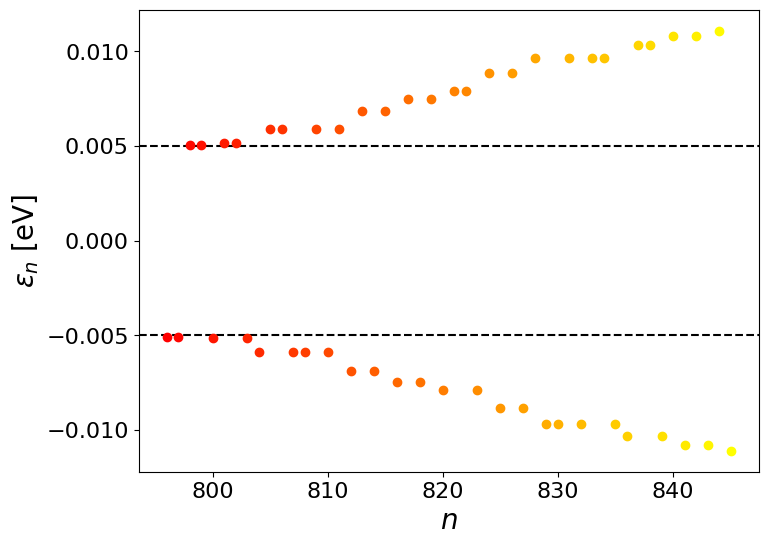

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# set to zero below a threshold
egvec_decoupled[np.abs(egvec_decoupled) < 1E-6] = 0
# eigenvalues to plot
ntot = len(egval_decoupled); ngap = ntot-rank; n = 50


# colors
cmap = plt.get_cmap('autumn', n)
# figure
fig, ax = plt.subplots(1,1, figsize=(8, 6))

# SC gap
ax.axhline(y=Delta, ls='--', color='black'); ax.axhline(y=-Delta, ls='--', color='black')

# loop over eigenvalues
for iegv in range(n):

    # effective index 
    ieff = ngap + iegv
    # plot energy
    ax.plot(ieff, egval_decoupled[ieff], 'o', label='n=' + str(ieff), c=cmap(iegv));

#ax.legend(fontsize=15, ncol=2, loc='center right')
ax.set_xlabel('$n$', fontsize = 20)
ax.set_ylabel('$\epsilon_n$ [eV]', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16);

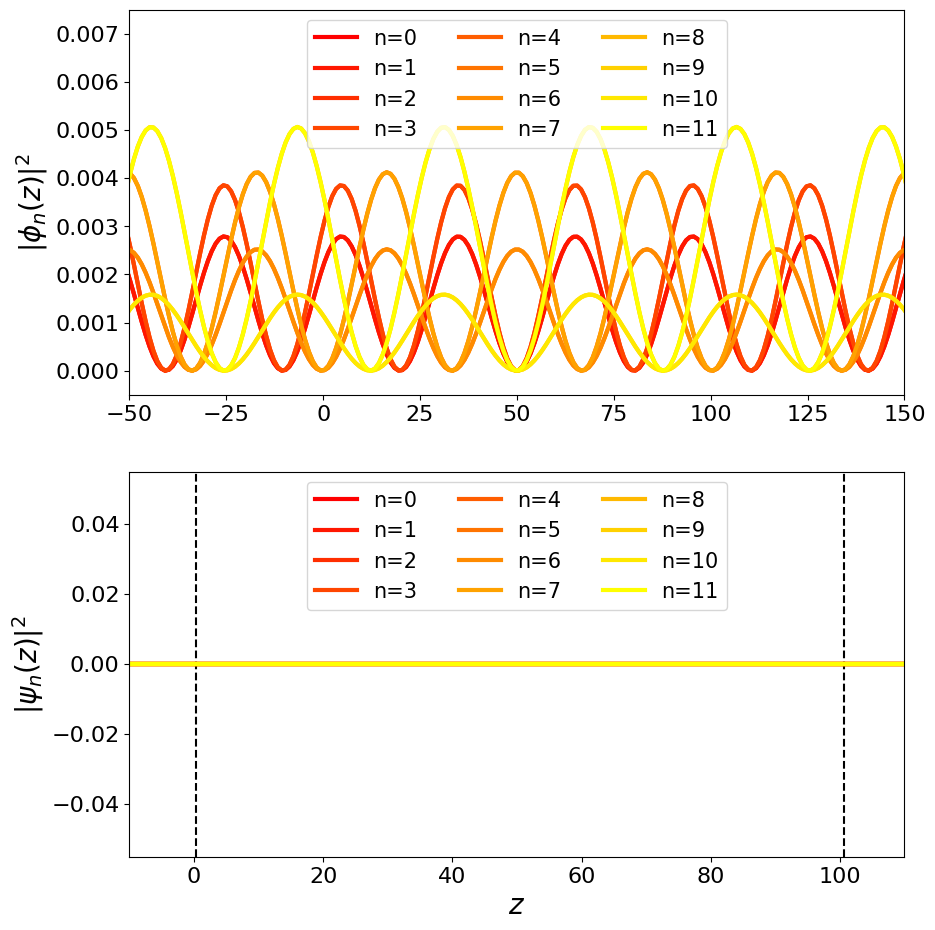

In [6]:
# get MTI spinors
spinorsMTI = getSpinors(egvec_decoupled, Nlat, type='eMTI')
# get SC spinors
spinorsSC = getSpinors(egvec_decoupled, Nlat, type='eSC')
# get full spinors
spinors = getSpinors(egvec_decoupled, Nlat)

# eigenvalues to plot
n = 12
# colors
cmap = plt.get_cmap('autumn', n)
# figure
fig, ax = plt.subplots(2,1, figsize=(10, 11))

# plot MTI interfaces
ax[1].axvline(x=lattice[100]-100, ls='--', color='black'); ax[1].axvline(x=lattice[200]-100, ls='--', color='black')

# loop over eigenvalues
for iegv in range(n):

    # effective index
    ieff = ngap + iegv
    
    # probability density for each lattice point for the SC states
    probdensSC = np.array([np.vdot(s, s) for s in spinorsSC[ieff]]).real
    # plot probability density in SC
    ax[0].plot(lattice-100, probdensSC, label='n=' + str(iegv), lw=3, c=cmap(iegv))
    
    # probability density for each lattice point for the MTI states
    probdensMTI = np.array([np.vdot(s, s) for s in spinorsMTI[ieff]]).real
    # plot probability density in MTI
    ax[1].plot(lattice-100, probdensMTI, label='n=' + str(iegv), lw=3, c=cmap(iegv))

    #probdens = np.array([np.vdot(s, s) for s in spinors[ieff]]).real    
    #print(iegv, round(np.trapz(probdensSC, x=lattice),4), round(np.trapz(probdensMTI, x=lattice),4), round(np.trapz(probdens, x=lattice),4))


# SC plot 
ax[0].set_xlim(-50., 150.)
ax[0].set_ylim(-0.0005, 0.0075)
ax[0].legend(fontsize=15, ncol=3)
ax[0].set_ylabel('$|\phi_n(z)|^2$', fontsize = 20)
ax[0].tick_params(axis='both', which='major', labelsize=16);

# MTI plot
ax[1].set_xlim(-10., 110.)
ax[1].legend(fontsize=15, loc='upper center', ncol=3)
ax[1].set_xlabel('$z$', fontsize = 20)
ax[1].set_ylabel('$|\psi_n(z)|^2$', fontsize = 20)
ax[1].tick_params(axis='both', which='major', labelsize=16);

#### <font color='green'> **MTI Spectrum** </font> 

Discrete energy spectrum around the energy of the lowest eigenstates of the MTI (corresponding to the topological surface states).

Surface states energy: 0.019599530686264903


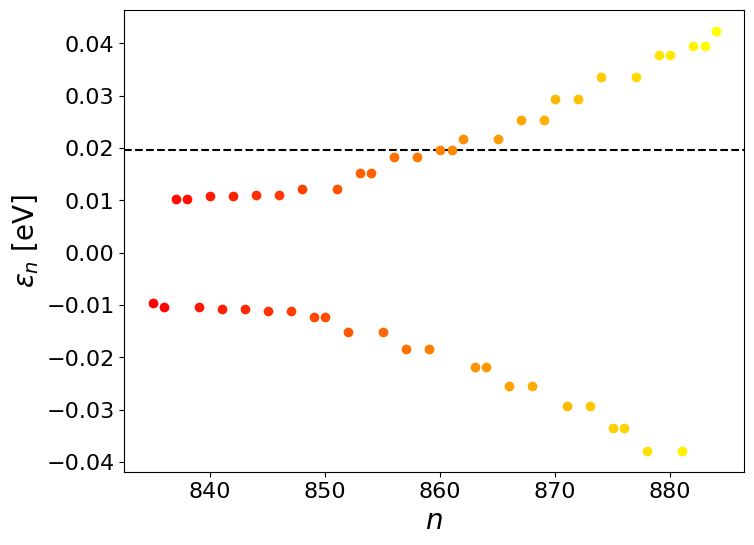

In [7]:
# find energy close to TSS
for iegv in range(ngap, ntot-ngap):

    # probability density for each lattice point for the MTI states
    probdensMTI = np.array([np.vdot(s, s) for s in spinorsMTI[iegv]]).real

    if np.trapz(probdensMTI, x=lattice) > 1E-5:
        n0 = iegv; break        

print('Surface states energy: ' + str(egval_decoupled[n0]))


# eigenvalues to plot
n = 50
# colors
cmap = plt.get_cmap('autumn', n)
# figure
fig, ax = plt.subplots(1,1, figsize=(8, 6))

# TSSs energy
ax.axhline(y=egval_decoupled[n0], ls='--', color='black')


# loop over eigenvalues
for iegv in range(n):

    # effective index 
    ieff = n0-25 + iegv
    # plot energy
    ax.plot(ieff, egval_decoupled[ieff], 'o', label='n=' + str(ieff), c=cmap(iegv));

#ax.legend(fontsize=15, ncol=2, loc='center right')
ax.set_xlabel('$n$', fontsize = 20)
ax.set_ylabel('$\epsilon_n$ [eV]', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16);

Energy eigenvalues:  [ 0.01959953  0.01960047  0.03959953  0.03960047  0.2632      0.26405077
 -0.27036204  0.27037762 -0.27266137 -0.2768     -0.27717421  0.2832    ]



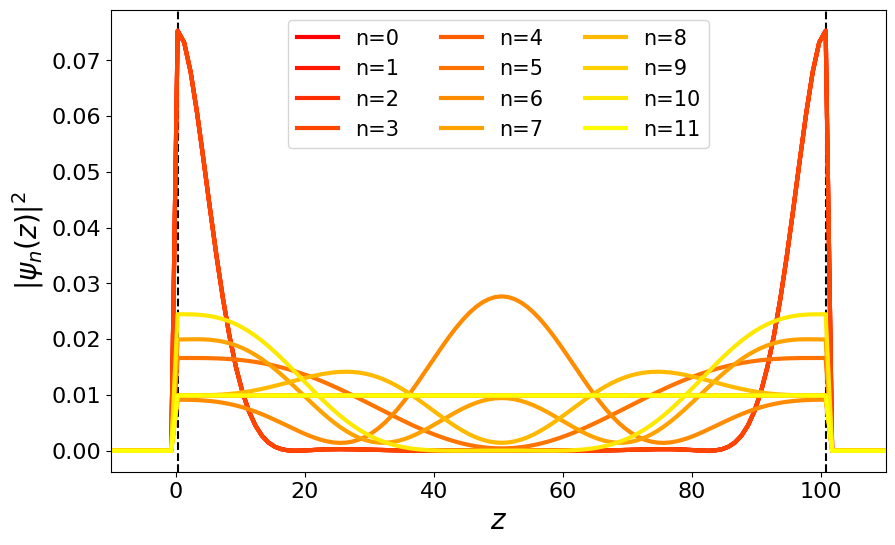

In [8]:
# get MTI spinors
spinorsMTI = getSpinors(egvec_decoupled, Nlat, type='eMTI')
# get SC spinors
spinorsSC = getSpinors(egvec_decoupled, Nlat, type='eSC')
# get full spinors
spinors = getSpinors(egvec_decoupled, Nlat)


# eigenvalues to plot
n = 12
# colors
cmap = plt.get_cmap('autumn', n)
# figure
fig, ax = plt.subplots(1,1, figsize=(10, 6))

# plot MTI interfaces
ax.axvline(x=lattice[100]-100, ls='--', color='black'); ax.axvline(x=lattice[200]-100, ls='--', color='black')


eMTI_states = 0; iegv = 0; ene = []
# infinite loop 
while True:
    
    # effective index
    ieff = n0 + iegv
    
    # probability density for each lattice point for the MTI states
    probdensMTI = np.array([np.vdot(s, s) for s in spinorsMTI[ieff]]).real

    if np.trapz(probdensMTI, x=lattice) > 1E-5:
        # plot probability density in MTI
        ax.plot(lattice-100, probdensMTI, label='n=' + str(eMTI_states), lw=3, c=cmap(eMTI_states))
        # count MTI states
        eMTI_states += 1; ene.append(egval_decoupled[ieff])

        # normalization
        #print(eMTI_states, np.trapz(probdensMTI, x=lattice))
        
    iegv +=  1

    # break condition
    if eMTI_states == n:
        break

print("Energy eigenvalues: ", np.array([e.real for e in ene]))
print()

# MTI plot 
ax.set_xlim(-10., 110.)
ax.legend(fontsize=15, loc='upper center', ncol=3)
ax.set_xlabel('$z$', fontsize = 20)
ax.set_ylabel('$|\psi_n(z)|^2$', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16);

#### <font color='green'> **MTI Components** </font> 

Energy eigenvalues:  [ 0.01959953  0.01960047  0.03959953  0.03960047  0.2632      0.26405077
 -0.27036204  0.27037762 -0.27266137 -0.2768     -0.27717421  0.2832    ]



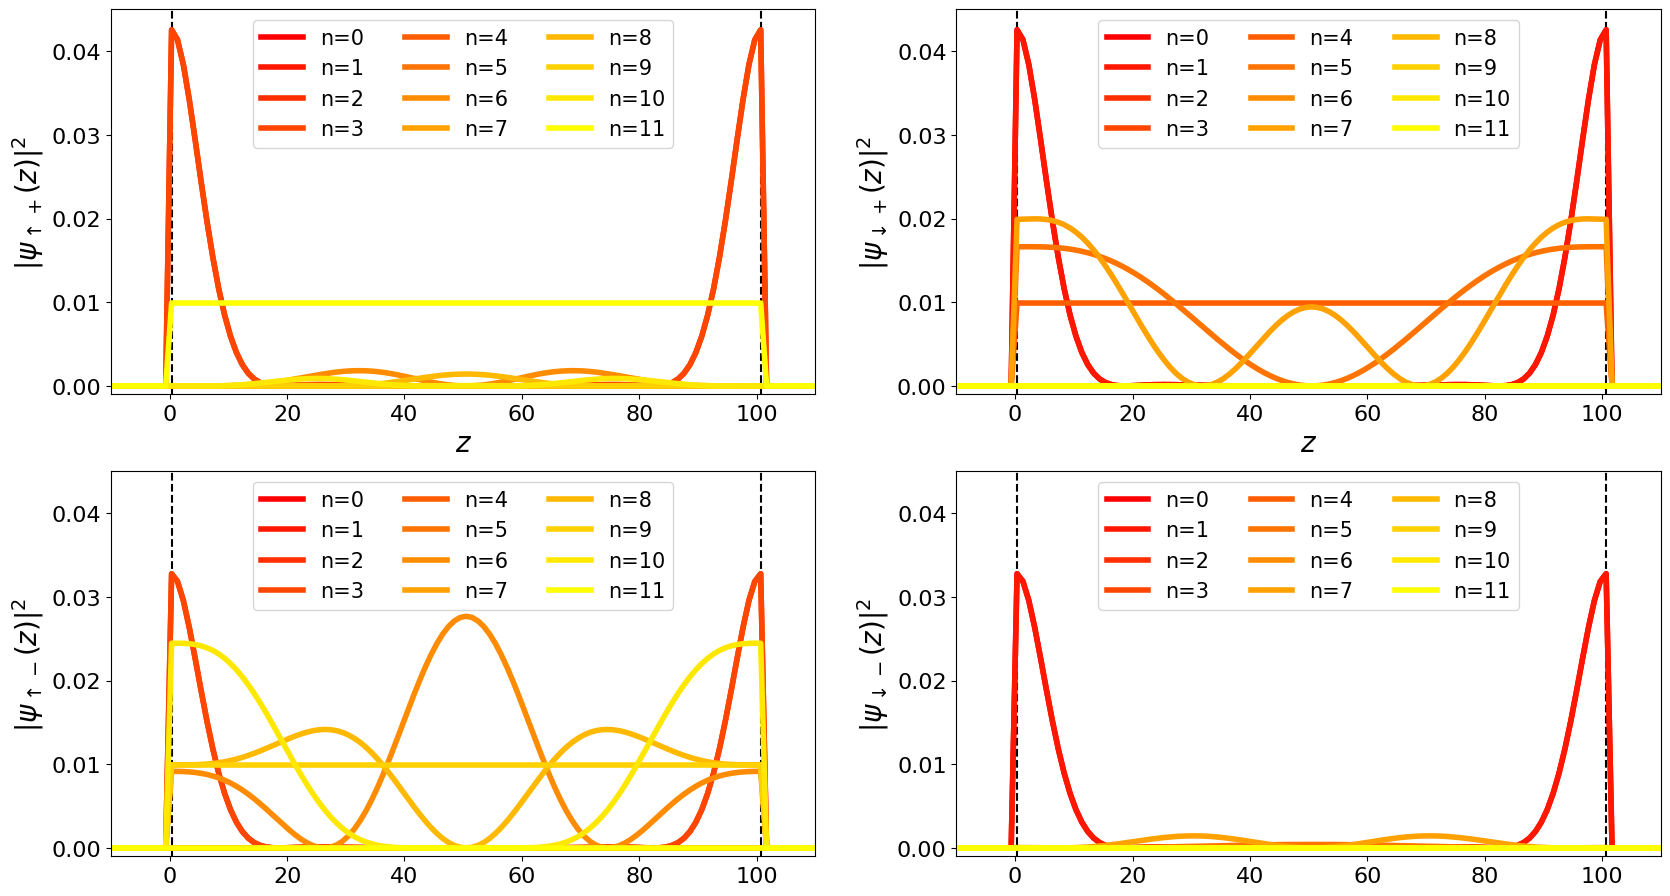

In [10]:
# get MTI spinors
compMTI = getComponents(egvec_decoupled, Nlat, type='eMTI')


# eigenvalues to plot
n = 12
# colors
cmap = plt.get_cmap('autumn', n)
# figure
fig, ax = plt.subplots(2,2, figsize=(20, 11))

for icomp in range(4):

    if icomp == 0: iax = 0; jax = 0
    if icomp == 1: iax = 0; jax = 1
    if icomp == 2: iax = 1; jax = 0
    if icomp == 3: iax = 1; jax = 1
        

    # plot MTI interfaces
    ax[iax][jax].axvline(x=lattice[100]-100, ls='--', color='black'); ax[iax][jax].axvline(x=lattice[200]-100, ls='--', color='black')

    eMTI_states = 0; iegv = 0; ene = []
    # infinite loop 
    while True:
    
        # effective index
        ieff = n0 + iegv 

        # probability density for each lattice point for the MTI states
        probdensMTI = np.array([np.vdot(s, s) for s in spinorsMTI[ieff]]).real
        # integrated density
        mti = np.trapz(probdensMTI, x=lattice)
        
        if mti > 0.05:

            # get components density
            comp = np.power(np.absolute(compMTI[icomp][ieff]),2)
            # plot probability density in MTI
            ax[iax][jax].plot(lattice-100, comp, label='n=' + str(eMTI_states), lw=4, c=cmap(eMTI_states))
            # append energies
            eMTI_states += 1; ene. append(egval_decoupled[ieff])
    
            # break condition
            if eMTI_states == n:
                break
            
        iegv +=  1


    if iax == 1: 
        ax[iax][jax].set_xlabel('$z$', fontsize = 20)
        
    ax[iax][jax].set_xlim(-10., 110.)
    ax[iax][jax].set_ylim(-0.001, 0.045)
    ax[iax][jax].legend(fontsize=15, loc='upper center', ncol=3)
    ax[iax][jax].tick_params(axis='both', which='major', labelsize=16);


ax[0][0].set_ylabel('$|\psi_{\\uparrow +}(z)|^2$', fontsize = 20);
ax[0][1].set_ylabel('$|\psi_{\downarrow +}(z)|^2$', fontsize = 20);
ax[1][0].set_ylabel('$|\psi_{\\uparrow -}(z)|^2$', fontsize = 20);
ax[1][1].set_ylabel('$|\psi_{\downarrow -}(z)|^2$', fontsize = 20);

print("Energy eigenvalues: ", np.array(ene))
print()

## **MTI-SC Heterostructure**

In [31]:
# lattice
Nlat = 300; d = 300.; dZ = d/(Nlat-1)
# parameters
mu = 0.010; Delta = 0.005; L = 0.010
# tunneling matrix
G = np.array([[1,0],[0,1],[1,0],[0,1]])

# compute the eigenstates of uncoupled system
rank, lattice, egval_full, egvec_full = eigenstates(kx=0., ky=0., mu=mu, Delta=Delta, L=L, Nlat=Nlat, dZ=dZ, zL=100, zR=200, z0=100, G=G)

print(rank, lattice.shape, egval_full.shape, egvec_full.shape)

1604 (300,) (2400,) (2400, 2400)


#### <font color='green'> **SC Spectrum** </font> 

Discrete energy spectrum around the SC energy gap $\Delta$.

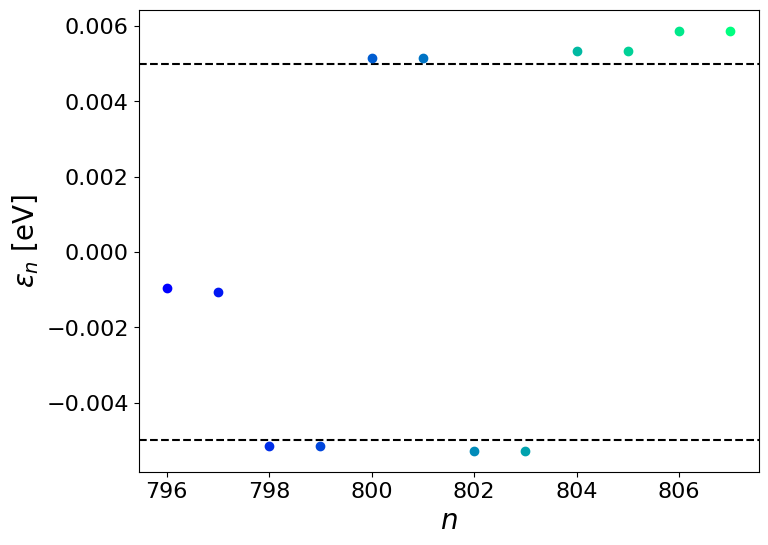

In [37]:
# set to zero below a threshold
#egvec_full[np.abs(egvec_full) < 1E-6] = 0
# eigenvalues to plot
ntot = len(egval_full); ngap = ntot-rank; n = 12


# colors
cmap = plt.get_cmap('winter', n)
# figure
fig, ax = plt.subplots(1,1, figsize=(8, 6))

# SC gap
ax.axhline(y=Delta, ls='--', color='black'); ax.axhline(y=-Delta, ls='--', color='black')

# loop over eigenvalues
for iegv in range(n):

    # effective index 
    ieff = ngap + iegv
    # plot energy
    ax.plot(ieff, egval_full[ieff], 'o', label='n=' + str(ieff), c=cmap(iegv));

#ax.legend(fontsize=15, ncol=2, loc='center right')
ax.set_xlabel('$n$', fontsize = 20)
ax.set_ylabel('$\epsilon_n$ [eV]', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16);

Energy eigenvalues:  [-0.0009578 -1.45591020e-05j -0.00105587+3.69070814e-06j
 -0.00515085-1.01711736e-09j -0.00515086+3.05196926e-10j
  0.00515145+2.51989854e-11j  0.00515145-1.42966023e-10j
 -0.00526981-2.57245143e-07j -0.00527124+7.92224971e-08j
  0.00533587+3.04353103e-08j]


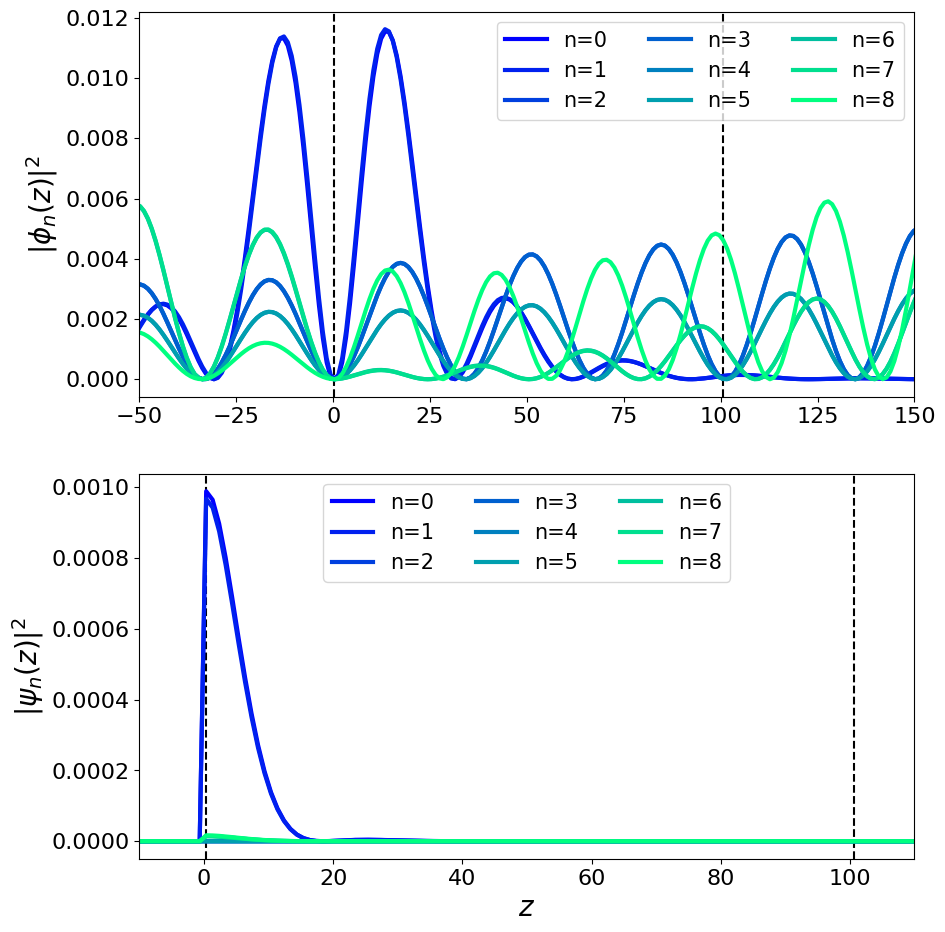

In [38]:
# get MTI spinors
spinorsMTI = getSpinors(egvec_full, Nlat, type='eMTI')
# get SC spinors
spinorsSC = getSpinors(egvec_full, Nlat, type='eSC')
# get SC spinors
spinorsSCh = getSpinors(egvec_full, Nlat, type='hSC')
# get full spinors
spinors = getSpinors(egvec_full, Nlat)

# eigenvalues to plot
n = 9;
# colors
cmap = plt.get_cmap('winter', n)
# figure
fig, ax = plt.subplots(2,1, figsize=(10, 11))

# plot MTI interfaces
ax[0].axvline(x=lattice[100]-100, ls='--', color='black'); ax[0].axvline(x=lattice[200]-100, ls='--', color='black')
ax[1].axvline(x=lattice[100]-100, ls='--', color='black'); ax[1].axvline(x=lattice[200]-100, ls='--', color='black')


ene = []
# loop over eigenvalues
for iegv in range(n):

    # effective index
    ieff = ngap + iegv 
    # append energies
    ene. append(egval_full[ieff])

    # probability density for each lattice point for the SC states
    probdensSC = np.array([np.vdot(s, s) for s in spinorsSC[ieff]]).real
    # plot probability density in SC
    ax[0].plot(lattice-100, probdensSC, label='n=' + str(iegv), lw=3, c=cmap(iegv))

    # probability density for each lattice point for the SC states
    probdensSCh = np.array([np.vdot(s, s) for s in spinorsSCh[ieff]]).real
    
    # probability density for each lattice point for the MTI states
    probdensMTI = np.array([np.vdot(s, s) for s in spinorsMTI[ieff]]).real
    # plot probability density in MTI
    ax[1].plot(lattice-100, probdensMTI, label='n=' + str(iegv), lw=3, c=cmap(iegv))

    '''
    e = np.trapz(probdensSC, x=lattice); h = np.trapz(probdensSCh, x=lattice); m = np.trapz(probdensMTI, x=lattice)
    print(e,h,m)
    print(e+h+m)
    print()
    '''

print("Energy eigenvalues: ", np.array(ene))

# SC plot 
ax[0].set_xlim(-50., 150.)
#ax[0].set_ylim(-0.0005, 0.0075)
ax[0].legend(fontsize=15, ncol=3)
ax[0].set_ylabel('$|\phi_n(z)|^2$', fontsize = 20)
ax[0].tick_params(axis='both', which='major', labelsize=16);

# MTI plot
ax[1].set_xlim(-10., 110.)
ax[1].legend(fontsize=15,  ncol=3)
ax[1].set_xlabel('$z$', fontsize = 20)
ax[1].set_ylabel('$|\psi_n(z)|^2$', fontsize = 20)
ax[1].tick_params(axis='both', which='major', labelsize=16);

#### <font color='green'> **MTI Spectrum** </font> 

Discrete energy spectrum around the energy of the topological surface states in the MTI.

Surface states energy: -0.021772568746077574


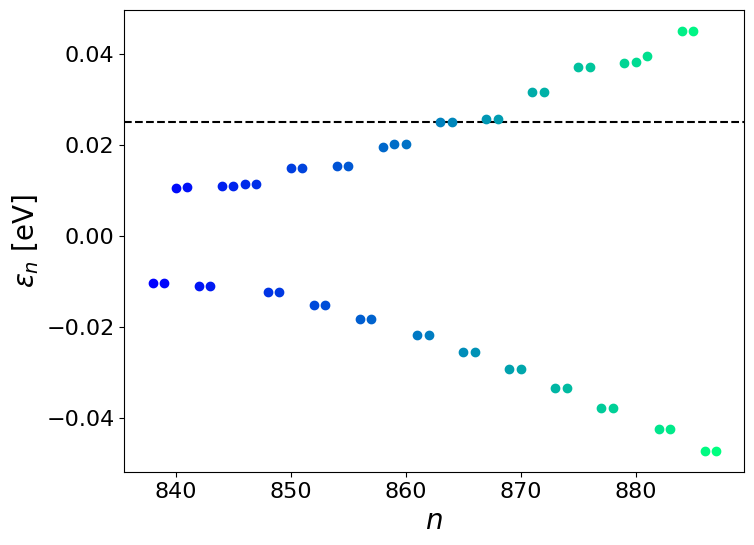

In [39]:
# find energy close to TSS
for iegv in range(ngap, ntot-ngap):

    if abs(egval_full[iegv]) > 0.0245: 
        n0 = iegv; break

print('Surface states energy: ' + str(egval_decoupled[n0]))

# eigenvalues to plot
n = 50
# colors
cmap = plt.get_cmap('winter', n)
# figure
fig, ax = plt.subplots(1,1, figsize=(8, 6))

# TSSs energy
ax.axhline(y=egval_full[n0], ls='--', color='black')


# loop over eigenvalues
for iegv in range(n):

    # effective index 
    ieff = n0-25 + iegv
    # plot energy
    ax.plot(ieff, egval_full[ieff], 'o', label='n=' + str(ieff), c=cmap(iegv));

#ax.legend(fontsize=15, ncol=2, loc='center right')
ax.set_xlabel('$n$', fontsize = 20)
ax.set_ylabel('$\epsilon_n$ [eV]', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16);

Energy eigenvalues:  [ 0.0396    -1.18589291e-12j -0.15730488-5.17618593e-02j
 -0.17164001+5.02182890e-02j  0.26333905+6.84660056e-05j
 -0.27094149+6.10851153e-04j -0.27159823-1.40930613e-03j
 -0.27681523-3.15723250e-05j -0.28572134+1.14064893e-03j
 -0.29093146-6.04854427e-04j -0.29161975+1.40053793e-03j
 -0.29681526+3.15453793e-05j -0.30563362-1.33432124e-03j]


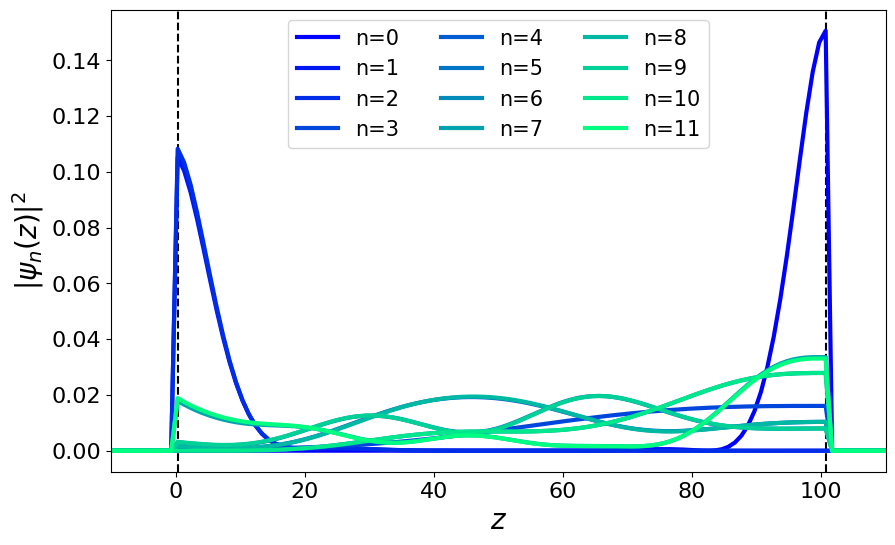

In [40]:
# get MTI spinors
spinorsMTI = getSpinors(egvec_full, Nlat, type='eMTI')
# get SC spinors
spinorsSC = getSpinors(egvec_full, Nlat, type='eSC')
# get full spinors
spinors = getSpinors(egvec_full, Nlat)


# eigenvalues to plot
n = 12
# colors
cmap = plt.get_cmap('winter', n)
# figure
fig, ax = plt.subplots(1,1, figsize=(10, 6))

# plot MTI interfaces
ax.axvline(x=lattice[100]-100, ls='--', color='black'); ax.axvline(x=lattice[200]-100, ls='--', color='black')


eMTI_states = 0; iegv = 0; ene = []
# infinite loop 
while True:
    
    # effective index
    ieff = n0 + iegv
    
    # probability density for each lattice point for the MTI states
    probdensMTI = np.array([np.vdot(s, s) for s in spinorsMTI[ieff]]).real

    if np.trapz(probdensMTI, x=lattice) > 0.5:
        # plot probability density in MTI
        ax.plot(lattice-100, probdensMTI, label='n=' + str(eMTI_states), lw=3, c=cmap(eMTI_states))
        # count MTI states
        eMTI_states += 1; ene.append(egval_full[ieff])

        #print(ieff, np.trapz(probdensMTI, x=lattice))
        
    iegv +=  1

    # break condition
    if eMTI_states == n:
        break

print("Energy eigenvalues: ", np.array(ene))

# MTI plot 
ax.set_xlim(-10., 110.)
ax.legend(fontsize=15, loc='upper center', ncol=3)
ax.set_xlabel('$z$', fontsize = 20)
ax.set_ylabel('$|\psi_n(z)|^2$', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16);

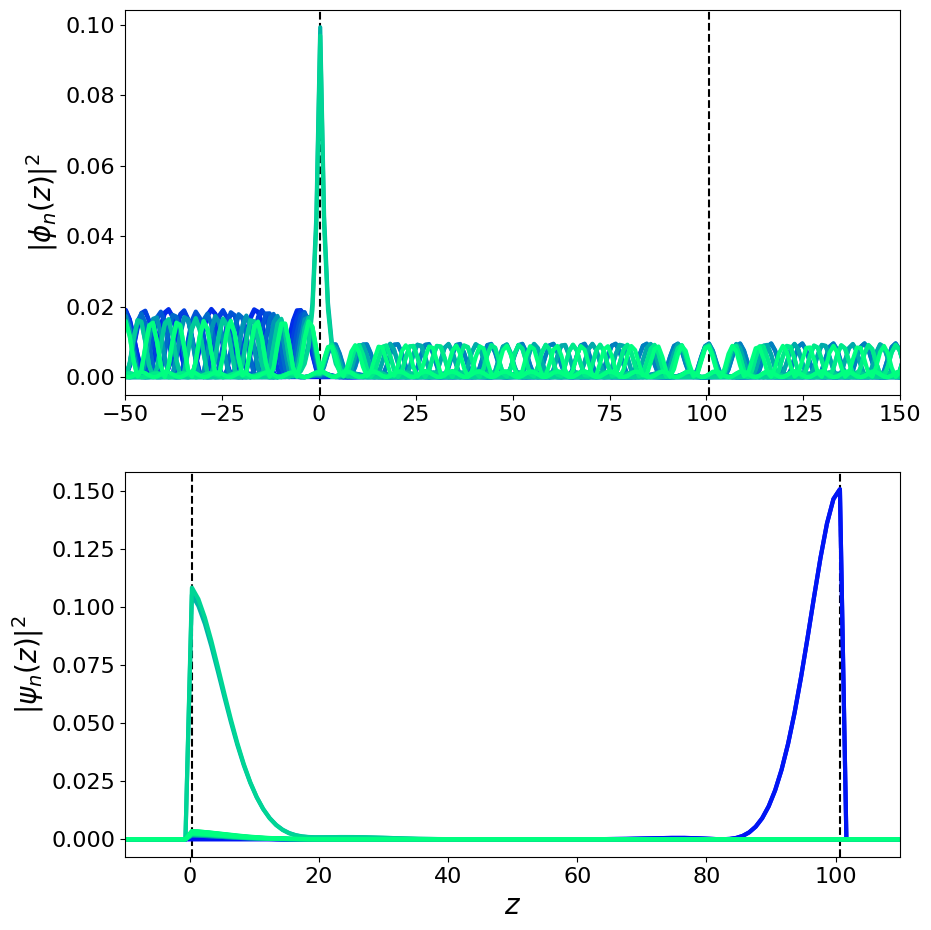

In [44]:
# get MTI spinors
spinorsMTI = getSpinors(egvec_full, Nlat, type='eMTI')
# get SC spinors
spinorsSC = getSpinors(egvec_full, Nlat, type='eSC')
# get SC spinors
spinorsSCh = getSpinors(egvec_full, Nlat, type='hSC')
# get full spinors
spinors = getSpinors(egvec_full, Nlat)

# eigenvalues to plot
n = 25
# colors
cmap = plt.get_cmap('winter', n)
# figure
fig, ax = plt.subplots(2,1, figsize=(10, 11))

# plot MTI interfaces
ax[0].axvline(x=lattice[100]-100, ls='--', color='black'); ax[0].axvline(x=lattice[200]-100, ls='--', color='black')
ax[1].axvline(x=lattice[100]-100, ls='--', color='black'); ax[1].axvline(x=lattice[200]-100, ls='--', color='black')


eMTI_states = 0; iegv = 0; ene = []
# infinite loop 
while True:

    # effective index
    ieff = ngap + iegv 

    # probability density for each lattice point for the SC states
    probdensSC = np.array([np.vdot(s, s) for s in spinorsSC[ieff]]).real
    
    # probability density for each lattice point for the MTI states
    probdensMTI = np.array([np.vdot(s, s) for s in spinorsMTI[ieff]]).real

    mti = np.trapz(probdensMTI, x=lattice)
    if mti > 0.01:
    
        # append energies
        eMTI_states += 1; ene.append(egval_full[ieff])
        # plot probability density in MTI
        ax[1].plot(lattice-100, probdensMTI, label='n=' + str(iegv), lw=3, c=cmap(eMTI_states))
        # plot probability density in SC
        ax[0].plot(lattice-100, probdensSC, label='n=' + str(iegv), lw=3, c=cmap(eMTI_states))

        # break condition
        if eMTI_states == n:
            break
        
    iegv +=  1

    
#print("Energy eigenvalues: ", np.array(ene))

# SC plot 
ax[0].set_xlim(-50., 150.)
#ax[0].set_ylim(-0.0005, 0.0075)
#ax[0].legend(fontsize=15, ncol=3)
ax[0].set_ylabel('$|\phi_n(z)|^2$', fontsize = 20)
ax[0].tick_params(axis='both', which='major', labelsize=16);

# MTI plot
ax[1].set_xlim(-10., 110.)
#ax[1].legend(fontsize=15,  ncol=3)
ax[1].set_xlabel('$z$', fontsize = 20)
ax[1].set_ylabel('$|\psi_n(z)|^2$', fontsize = 20)
ax[1].tick_params(axis='both', which='major', labelsize=16);

#### <font color='green'> **MTI Components** </font> 

Energy eigenvalues:  [0.0396    -1.18589291e-12j 0.06715683+3.41077210e-05j
 0.06731587-1.10862006e-05j 0.08485545+7.98000555e-05j
 0.08504843-3.77397902e-05j 0.10431232+1.60168498e-04j
 0.10453306-9.33292600e-05j 0.12550773+2.86317054e-04j
 0.12574463-1.90506179e-04j]


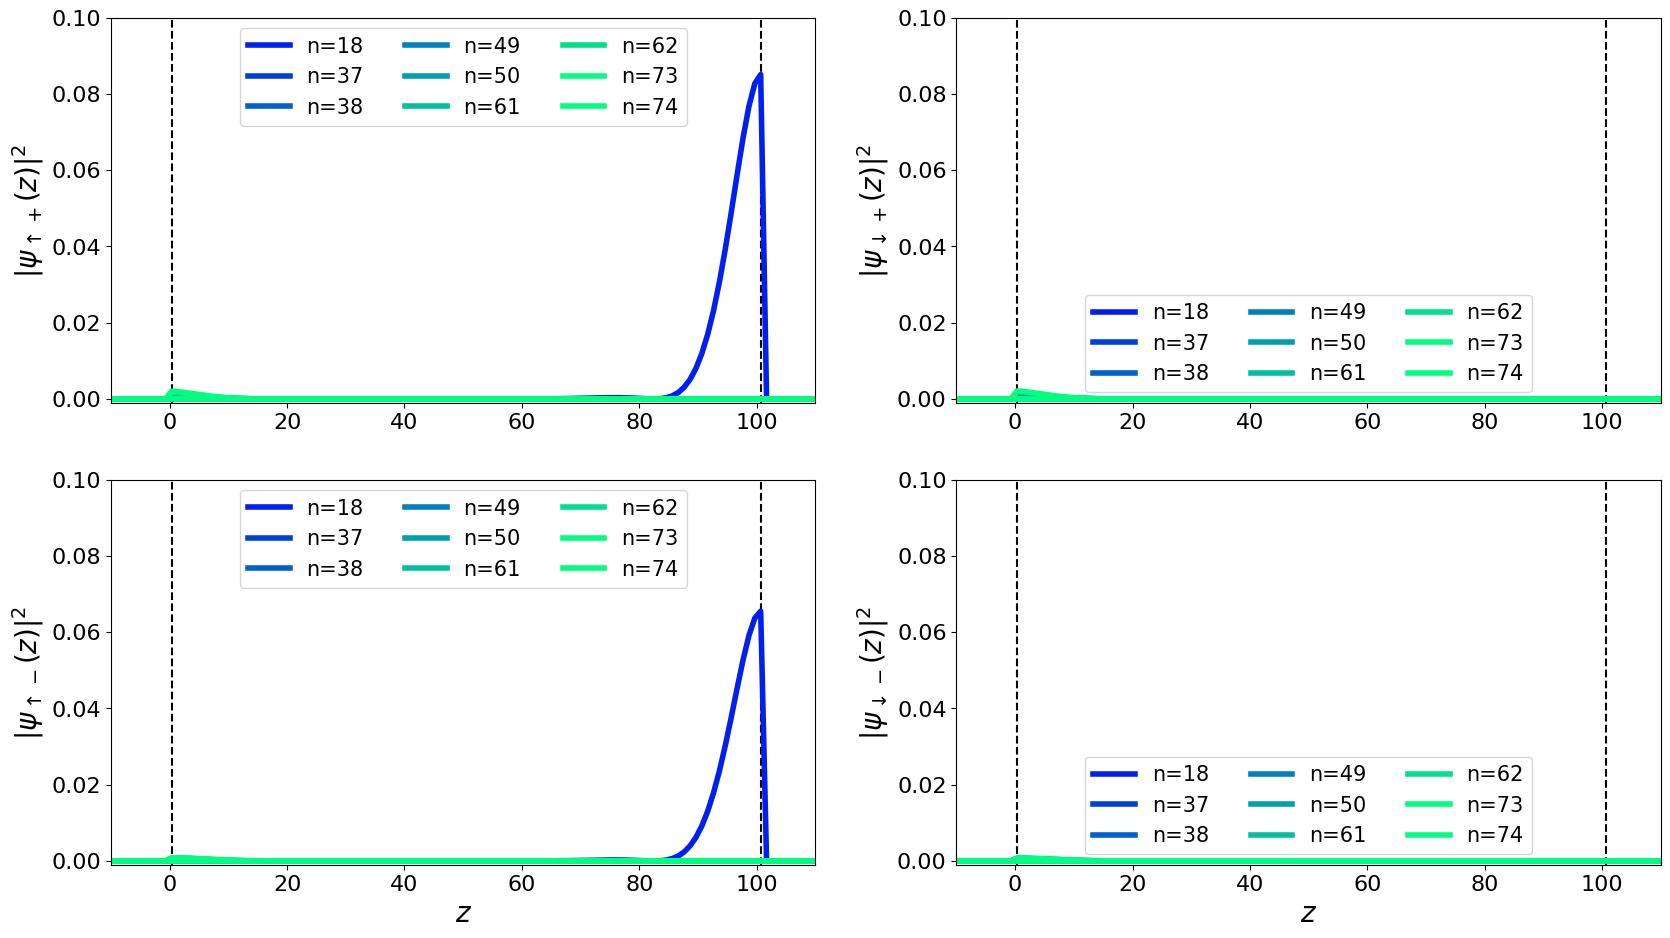

In [48]:
# get MTI spinors
compMTI = getComponents(egvec_full, Nlat, type='eMTI')


# eigenvalues to plot
n = 9
# colors
cmap = plt.get_cmap('winter', n)
# figure
fig, ax = plt.subplots(2,2, figsize=(20, 11))

for icomp in range(4):

    if icomp == 0: iax = 0; jax = 0
    if icomp == 1: iax = 0; jax = 1
    if icomp == 2: iax = 1; jax = 0
    if icomp == 3: iax = 1; jax = 1
        

    # plot MTI interfaces
    ax[iax][jax].axvline(x=lattice[100]-100, ls='--', color='black'); ax[iax][jax].axvline(x=lattice[200]-100, ls='--', color='black')

    eMTI_states = 0; iegv = 0; ene = []
    # infinite loop 
    while True:
    
        # effective index
        ieff = n0  + iegv 

        # probability density for each lattice point for the MTI states
        probdensMTI = np.array([np.vdot(s, s) for s in spinorsMTI[ieff]]).real
        # integrated density
        mti = np.trapz(probdensMTI, x=lattice)
        
        if mti > 0.01:

            comp = np.power(np.absolute(compMTI[icomp][ieff]),2)
            
            # append energies
            eMTI_states += 1; ene.append(egval_full[ieff])
            # plot probability density in MTI
            ax[iax][jax].plot(lattice-100, comp, label='n=' + str(iegv), lw=4, c=cmap(eMTI_states))

    
            # break condition
            if eMTI_states == n:
                break
            
        iegv +=  1


    if iax == 1: 
        ax[iax][jax].set_xlabel('$z$', fontsize = 20)
        
    ax[iax][jax].set_xlim(-10., 110.)
    ax[iax][jax].set_ylim(-0.001, 0.1); #ax[iax][jax].set_ylim(-0.001, 0.005)
    ax[iax][jax].tick_params(axis='both', which='major', labelsize=16);
    ax[iax][jax].legend(fontsize=15,  ncol=3)

ax[0][0].set_ylabel('$|\psi_{\\uparrow +}(z)|^2$', fontsize = 20);
ax[0][1].set_ylabel('$|\psi_{\downarrow +}(z)|^2$', fontsize = 20);
ax[1][0].set_ylabel('$|\psi_{\\uparrow -}(z)|^2$', fontsize = 20);
ax[1][1].set_ylabel('$|\psi_{\downarrow -}(z)|^2$', fontsize = 20);

print("Energy eigenvalues: ", np.array(ene))

# Green's Function

### **Decoupled System** 

In [55]:
from MTI_Analytical import GMTI_analytical
from MTI_Differential_Equation import GMTI_NeumannBC
from MTI_Discretization import eigenstates_Neumann, GMTI_discretized

# energy
omega = 0.0025

# discrete lattice for MTI only
Nlat_0 = 250; d = 100.; dZ_0 = d/(Nlat_0-1)
# discretized eigenstates (MTI only)
lattice_0, egval_0, spinors_0 = eigenstates_Neumann(Nlat=Nlat_0, dZ=dZ_0, kx=0., ky=0., L=L)
# compute G0-MTI with  MTI only
g_0 = np.array([ GMTI_discretized(Nstates=250, egval=egval_0, spinors=spinors_0, z=z, Z=z, w=omega) for z in range(Nlat_0)])

# get MTI spinors (decoupled system)
spinors_decoupled = getSpinors(egvec_decoupled, Nlat, type='eMTI')
# compute G-MTI without tunneling 
g_decoupled = np.array([GMTI_discretized(Nstates=rank, egval=egval_decoupled, spinors=spinors_decoupled, z=z, Z=z, w=omega, n0=ngap) for z in range(Nlat)])

# compute G-MTI from diff. eq.
g_diff_eq = np.array([GMTI_NeumannBC(d=d, z=z, Z=z, kx=0., ky=0., L=L, w=omega) for z in lattice_0])

#### <font color='green'> **Real Part** </font> 

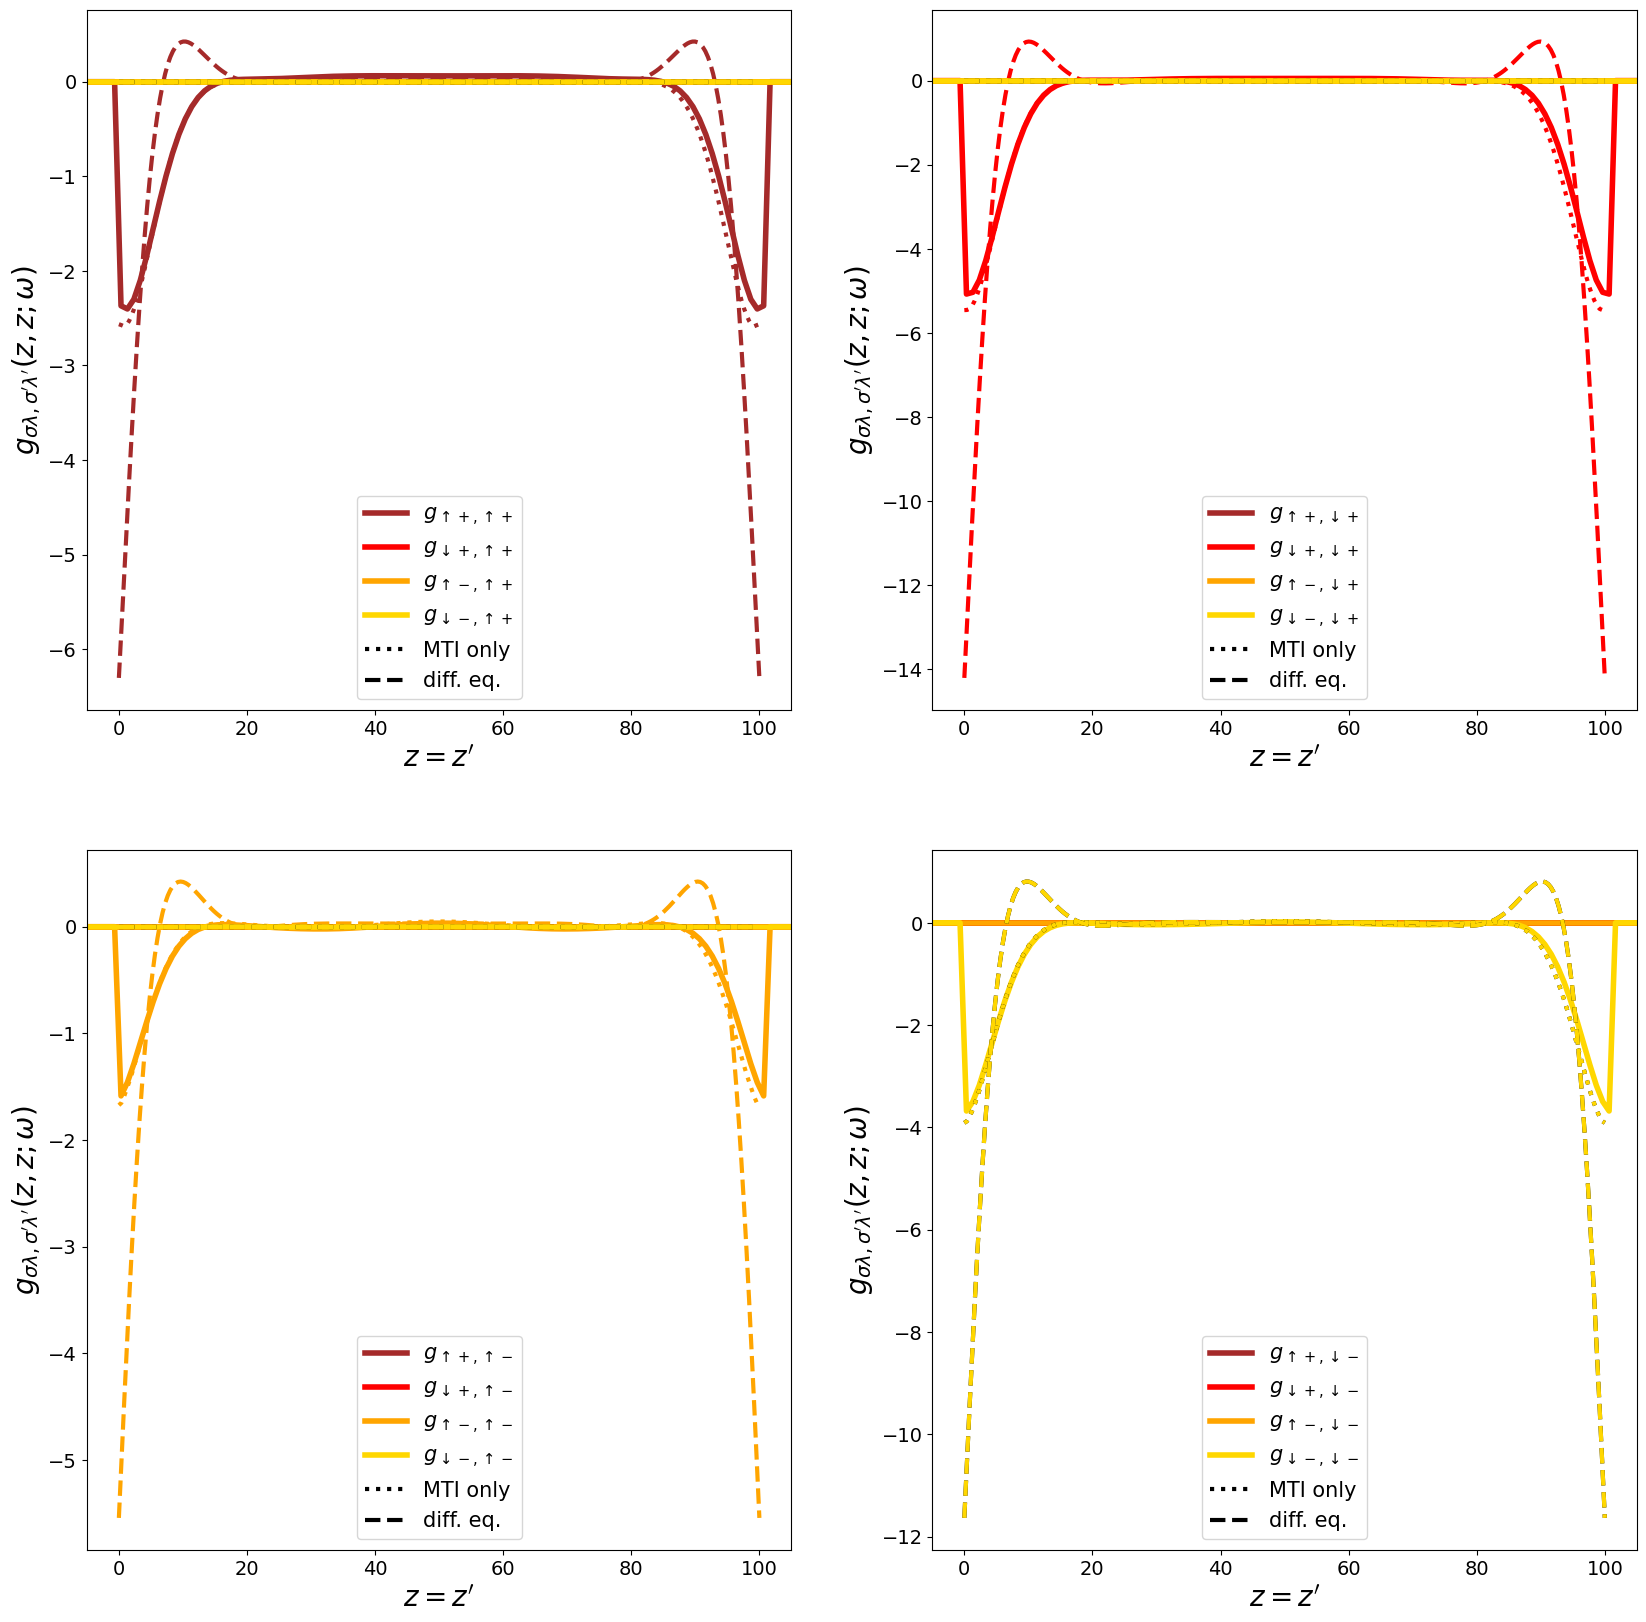

In [57]:
# colors for plotting
colors = ['brown', 'red', 'orange', 'gold']
# labels for curves
labels = [["$g_{\\uparrow +, \\uparrow +}$", "$g_{\\uparrow +, \downarrow +}$", "$g_{\\uparrow +, \\uparrow -}$", "$g_{\\uparrow +, \downarrow -}$"],
          ["$g_{\downarrow +, \\uparrow +}$", "$g_{\downarrow +, \downarrow +}$", "$g_{\downarrow +, \\uparrow -}$", "$g_{\downarrow +, \downarrow -}$"],
          ["$g_{\\uparrow -, \\uparrow +}$", "$g_{\\uparrow -, \downarrow +}$", "$g_{\\uparrow -, \\uparrow -}$", "$g_{\\uparrow -, \downarrow -}$"],
          ["$g_{\downarrow -, \\uparrow +}$", "$g_{\downarrow -, \downarrow +}$", "$g_{\downarrow -, \\uparrow -}$", "$g_{\downarrow -, \downarrow -}$"]]


# subplots
fig, axs = plt.subplots(2,2, figsize=(20, 20))

# indices referred to GF matrix
for icol in range(4):
        
    # indices for plotting
    if icol==0: iPic = 0; jPic = 0
    if icol==1: iPic = 0; jPic = 1
    if icol==2: iPic = 1; jPic = 0
    if icol==3: iPic = 1; jPic = 1
    
    for irow in range(4):

        # plot G decoupled (full discretization with Gamma=0)
        axs[iPic][jPic].plot(lattice-100, [g_decoupled[idx][irow][icol].real for idx in range(Nlat)], c=colors[irow], lw=4, label=labels[irow][icol] )

        # fake plot for legend
        if irow == 3:
            axs[iPic][jPic].plot(lattice_0, [g_0[idx][irow][icol].real for idx in range(Nlat_0)], c='black', lw=3, ls=':', label='MTI only' )
            axs[iPic][jPic].plot(lattice_0, [g_diff_eq[idx][irow][icol].real for idx in range(Nlat_0)], c='black', lw=3, ls='--',  label='diff. eq.') 
        
        # plot G0 with MTI only (discretized)
        axs[iPic][jPic].plot(lattice_0, [g_0[idx][irow][icol].real for idx in range(Nlat_0)], c=colors[irow], lw=3, ls=':')  
        
        # plot G0 as solution of diff. eq. (Neumann BC)
        axs[iPic][jPic].plot(lattice_0, [g_diff_eq[idx][irow][icol].real for idx in range(Nlat_0)], c=colors[irow], lw=3, ls='--') 
    
    axs[iPic][jPic].set_xlim(-5,105)
    axs[iPic][jPic].set_xlabel("$z=z'$", fontsize = 20)
    axs[iPic][jPic].set_ylabel("$g_{\sigma\lambda, \sigma'\lambda'}(z,z;\omega)$", fontsize = 20)
        
    axs[iPic][jPic].tick_params(axis='both', which='major', labelsize=14)        
    axs[iPic][jPic].legend(fontsize=15);

#### <font color='green'> **Imaginary Part** </font> 

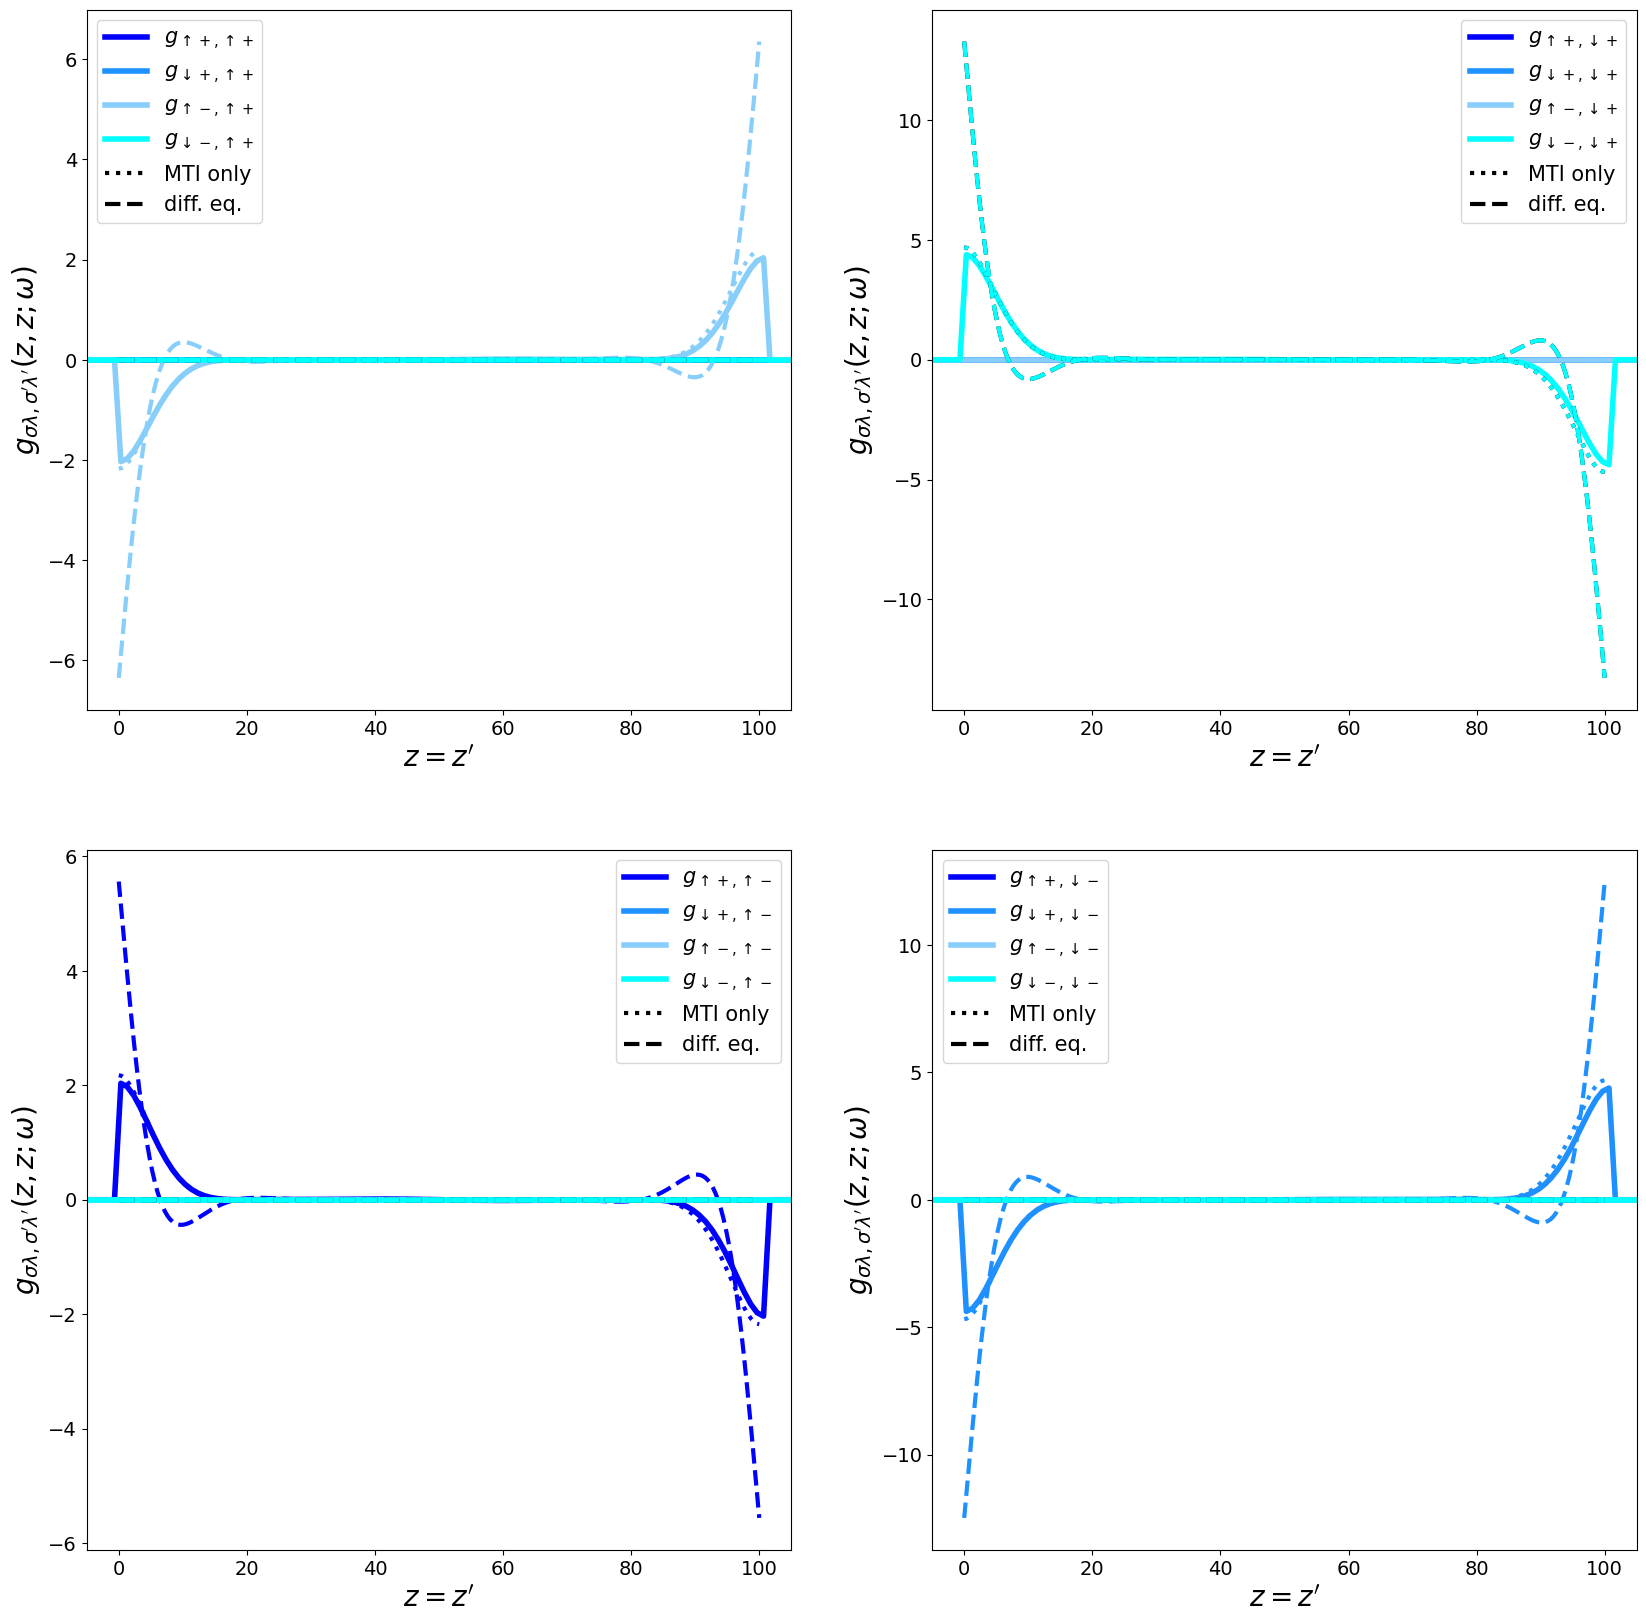

In [59]:
# colors for plotting
colors = ['blue','dodgerblue','lightskyblue','cyan']

# subplots
fig, axs = plt.subplots(2,2, figsize=(20, 20))

# indices referred to GF matrix
for icol in range(4):
        
    # indices for plotting
    if icol==0: iPic = 0; jPic = 0
    if icol==1: iPic = 0; jPic = 1
    if icol==2: iPic = 1; jPic = 0
    if icol==3: iPic = 1; jPic = 1
    
    for irow in range(4):

        # plot G decoupled (full discretization with Gamma=0)
        axs[iPic][jPic].plot(lattice-100, [g_decoupled[idx][irow][icol].imag for idx in range(Nlat)], c=colors[irow], lw=4, label=labels[irow][icol] )

        # fake plot for legend
        if irow == 3:
            axs[iPic][jPic].plot(lattice_0, [g_0[idx][irow][icol].imag for idx in range(Nlat_0)], c='black', lw=3, ls=':', label='MTI only' )
            axs[iPic][jPic].plot(lattice_0, [g_diff_eq[idx][irow][icol].imag for idx in range(Nlat_0)], c='black', lw=3, ls='--',  label='diff. eq.') 
        
        # plot G0 with MTI only (discretized)
        axs[iPic][jPic].plot(lattice_0, [g_0[idx][irow][icol].imag for idx in range(Nlat_0)], c=colors[irow], lw=3, ls=':')  
        
        # plot G0 as solution of diff. eq. (Neumann BC)
        axs[iPic][jPic].plot(lattice_0, [g_diff_eq[idx][irow][icol].imag for idx in range(Nlat_0)], c=colors[irow], lw=3, ls='--') 
        

    axs[iPic][jPic].set_xlim(-5,105)
    axs[iPic][jPic].set_xlabel("$z=z'$", fontsize = 20)
    axs[iPic][jPic].set_ylabel("$g_{\sigma\lambda, \sigma'\lambda'}(z,z;\omega)$", fontsize = 20)
        
    axs[iPic][jPic].tick_params(axis='both', which='major', labelsize=14)        
    axs[iPic][jPic].legend(fontsize=15);

### **MTI-SC Heterostructure** 

In [60]:
from MTI_Analytical import GMTI_analytical
from MTI_Second_Order import GMTI2_analytical

# lattice
Nlat = 300; d = 300.; dZ = d/(Nlat-1)
# parameters
mu = 0.010; Delta = 0.005; L = 0.010
# tunneling matrix
G = np.matrix([[1,0],[0,1],[1,0],[1,0]])

# get MTI spinors (decoupled system)
spinors_full = getSpinors(egvec_full, Nlat, type='eMTI')
# compute G-MTI without tunneling 
g_full = np.array([GMTI_discretized(Nstates=rank, egval=egval_full, spinors=spinors_full, z=z, Z=z, w=omega, n0=ngap) for z in range(Nlat)])

'''
# lattice 
d = 100.
# z-lattice for calculation
Z = np.linspace(0., d, 250)
# G0 computed analytically (mixed BC)
G0 = np.array([GMTI_analytical(d=d, z=z, Z=z, L=L, omega=omega) for z in Z])
# G2 computed analytically (mixed BC)
G2 = np.array([GMTI2_analytical(d=d, z=z, Z=z, z0=0, L=L, mu=mu, Delta=Delta, omega=omega, Gamma=G) for z in Z])
'''

'\n# lattice \nd = 100.\n# z-lattice for calculation\nZ = np.linspace(0., d, 250)\n# G0 computed analytically (mixed BC)\nG0 = np.array([GMTI_analytical(d=d, z=z, Z=z, L=L, omega=omega) for z in Z])\n# G2 computed analytically (mixed BC)\nG2 = np.array([GMTI2_analytical(d=d, z=z, Z=z, z0=0, L=L, mu=mu, Delta=Delta, omega=omega, Gamma=G) for z in Z])\n'

#### <font color='green'> **Real Part** </font> 

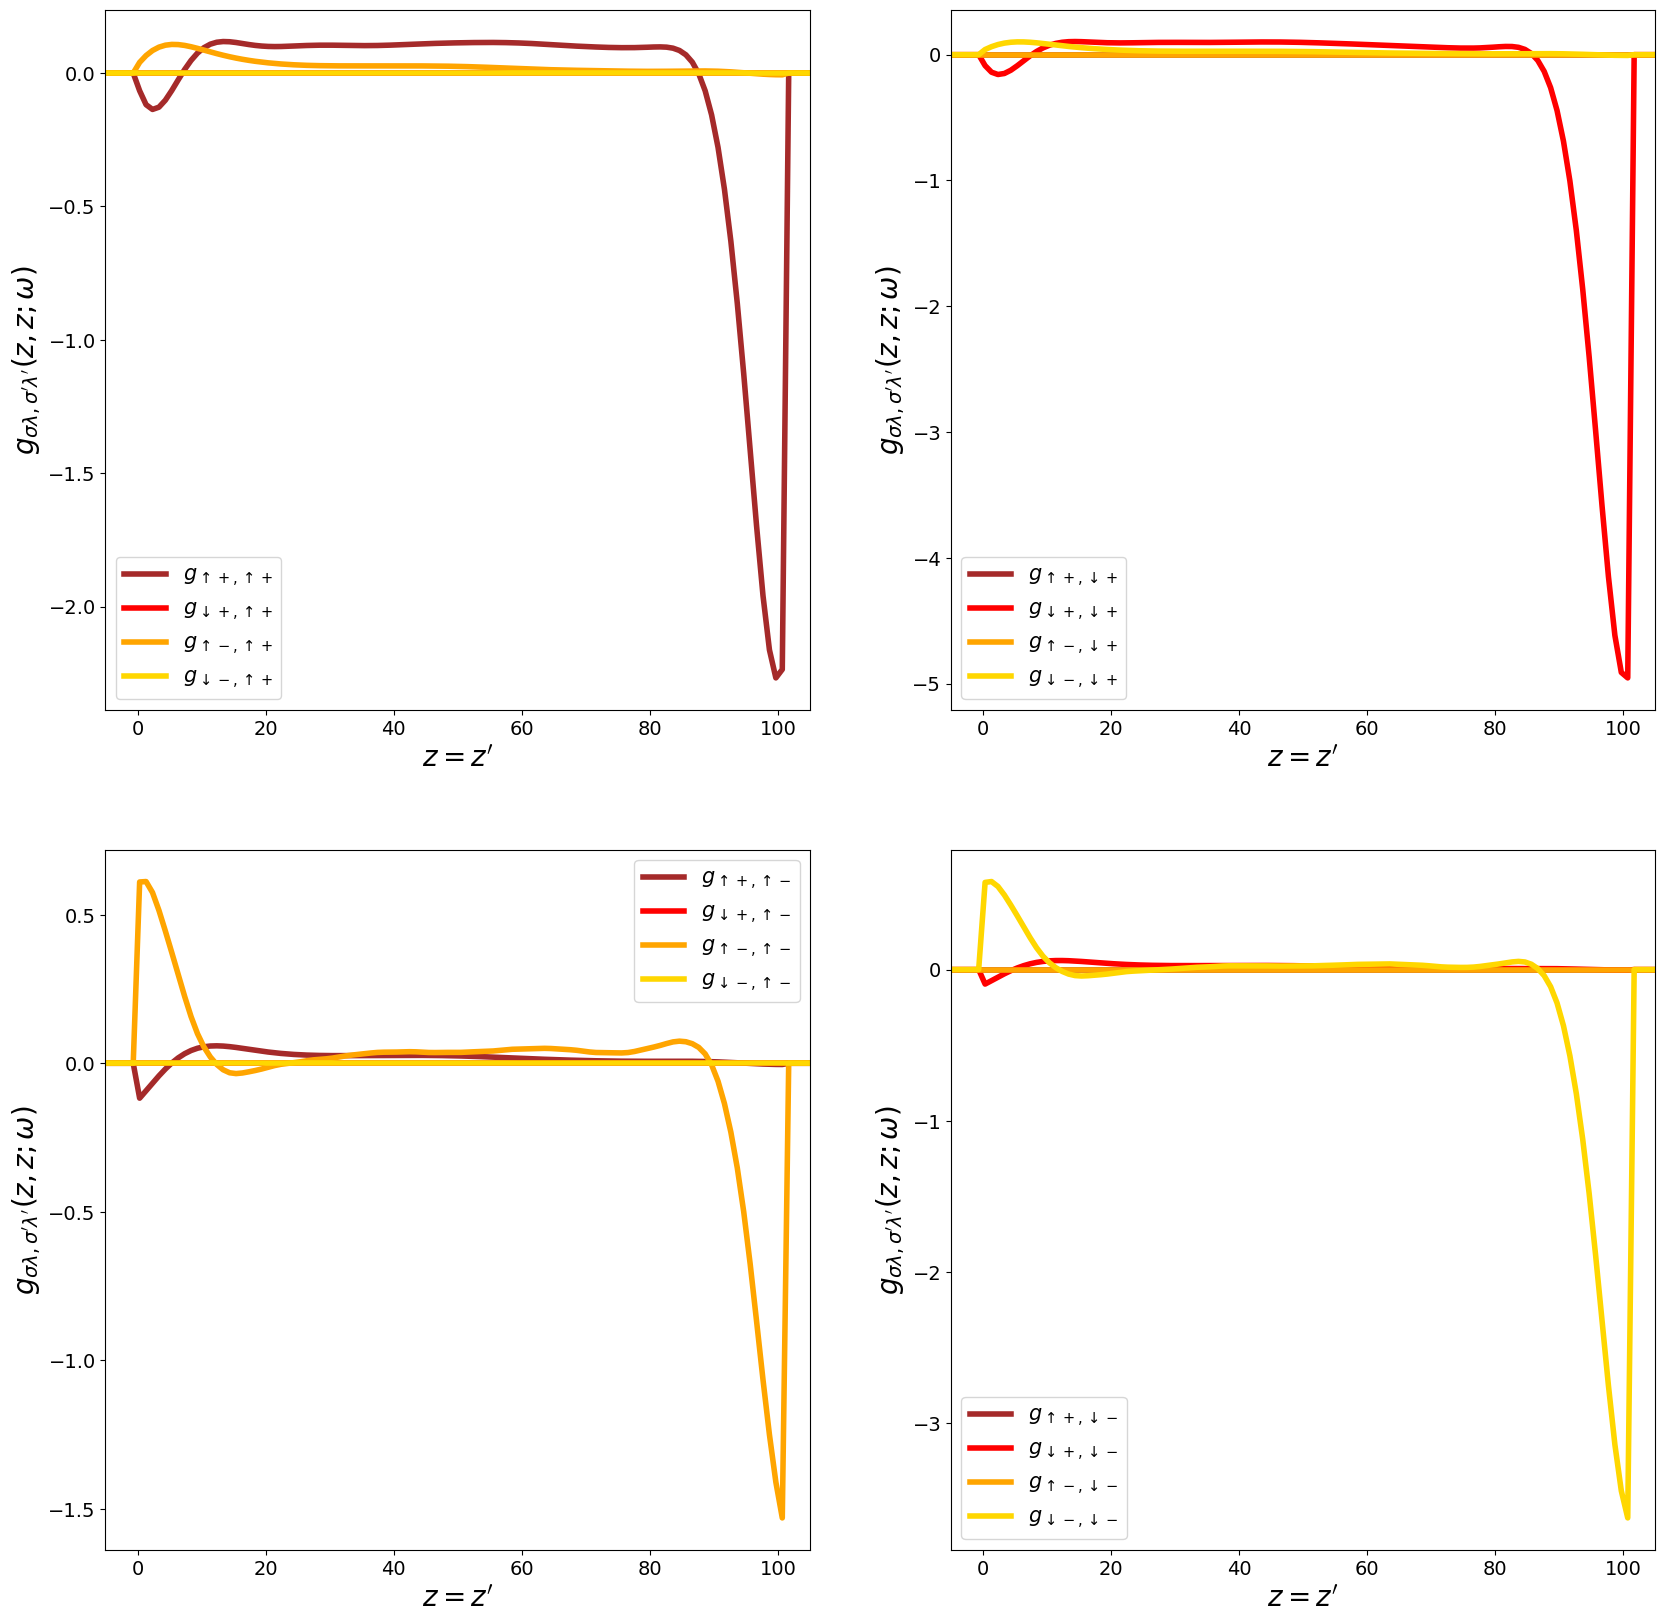

In [65]:
# colors for plotting
colors = ['brown', 'red', 'orange', 'gold']
# subplots
fig, axs = plt.subplots(2,2, figsize=(20, 20))


# indices referred to GF matrix
for icol in range(4):
        
    # indices for plotting
    if icol==0: iPic = 0; jPic = 0
    if icol==1: iPic = 0; jPic = 1
    if icol==2: iPic = 1; jPic = 0
    if icol==3: iPic = 1; jPic = 1
    
    for irow in range(4):

        # plot G_full (discretization)
        axs[iPic][jPic].plot(lattice-100, [g_full[idx][irow][icol].real for idx in range(Nlat)], c=colors[irow], lw=4, label=labels[irow][icol] )
        

    axs[iPic][jPic].set_xlim(-5,105)
    axs[iPic][jPic].set_xlabel("$z=z'$", fontsize = 20)
    axs[iPic][jPic].set_ylabel("$g_{\sigma\lambda, \sigma'\lambda'}(z,z;\omega)$", fontsize = 20)
        
    axs[iPic][jPic].tick_params(axis='both', which='major', labelsize=14)        
    axs[iPic][jPic].legend(fontsize=15);

#### <font color='green'> **Imaginary Part** </font> 

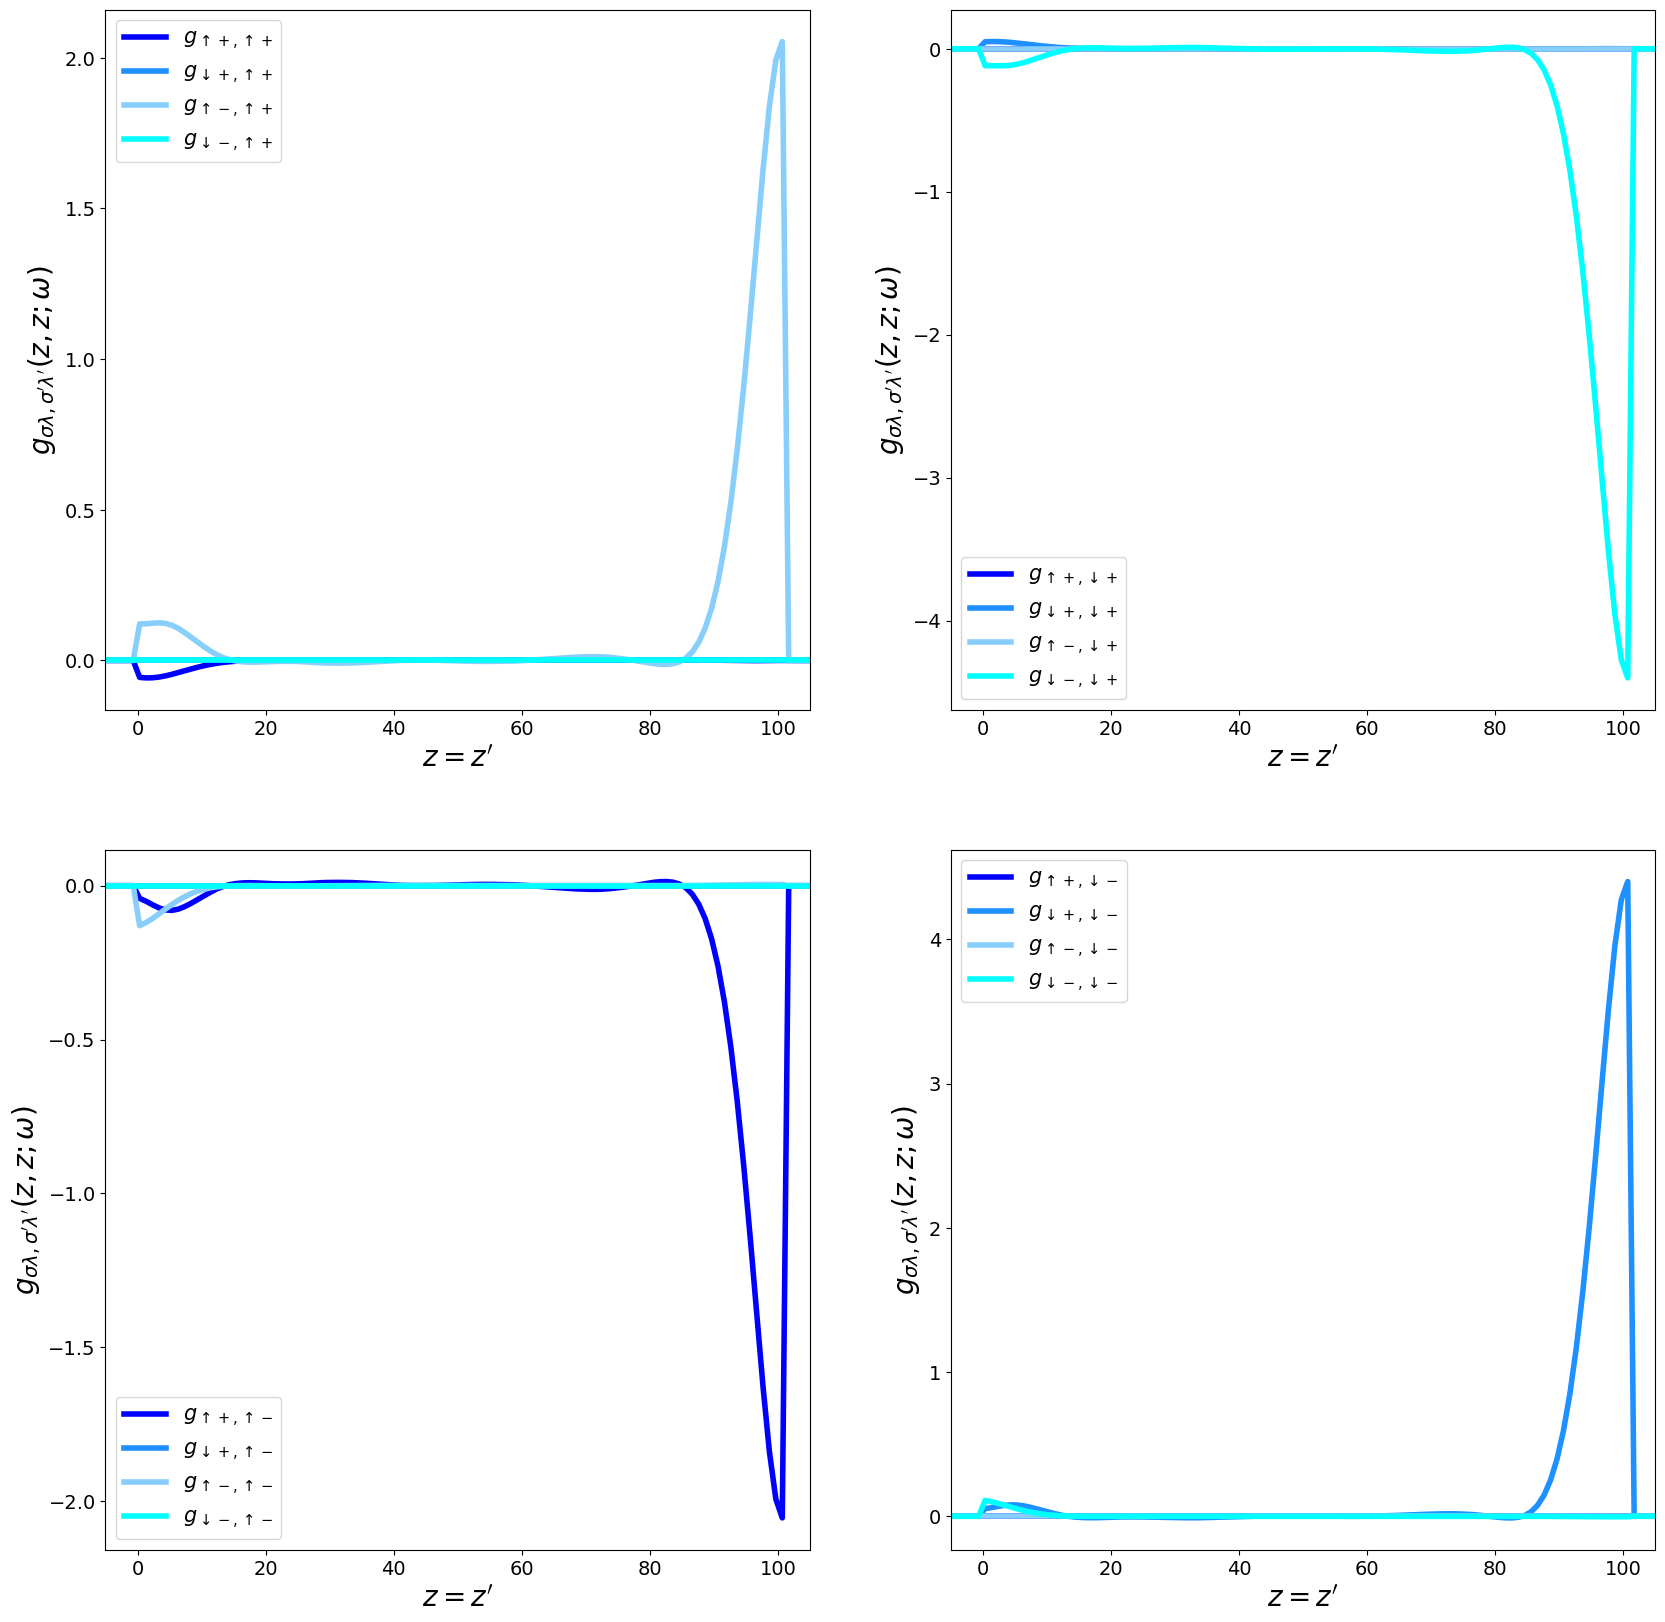

In [62]:
# colors for plotting
colors = ['blue','dodgerblue','lightskyblue','cyan']

# subplots
fig, axs = plt.subplots(2,2, figsize=(20, 20))

# indices referred to GF matrix
for icol in range(4):
        
    # indices for plotting
    if icol==0: iPic = 0; jPic = 0
    if icol==1: iPic = 0; jPic = 1
    if icol==2: iPic = 1; jPic = 0
    if icol==3: iPic = 1; jPic = 1
    
    for irow in range(4):

        # plot G_full (discretization)
        axs[iPic][jPic].plot(lattice-100, [g_full[idx][irow][icol].imag for idx in range(Nlat)], c=colors[irow], lw=4, label=labels[irow][icol] )

    
    axs[iPic][jPic].set_xlim(-5,105)
    axs[iPic][jPic].set_xlabel("$z=z'$", fontsize = 20)
    axs[iPic][jPic].set_ylabel("$g_{\sigma\lambda, \sigma'\lambda'}(z,z;\omega)$", fontsize = 20)
        
    axs[iPic][jPic].tick_params(axis='both', which='major', labelsize=14)        
    axs[iPic][jPic].legend(fontsize=15);